In [1]:
from pyspark.sql.functions import col, isnan, isnull, when, count, udf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

In [2]:
config_file_path = 'config.json'

with open(config_file_path, 'r') as config_file:
    config = json.load(config_file)

#spark log level to show errors
sc.setLogLevel("ERROR")
#setting up path + reading my csv from bucket
bucket=config["bucket"]
filename=config["featureengineeringoutput"]
file_path = 'gs://'+ bucket+'/'+filename

sdf= spark.read.parquet(file_path)

sdf.printSchema()

root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: double (nullable = true)
 |-- totalTravelDistance: double (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: string (nullable = true)
 |-- segmentsAirlineCode: string (nullable = true)
 |-- segmentsCabinCode: string (nullable = true)
 |-- leadTime: integer (nullable = true)
 |-- scaledvector: vector (nullable = true)
 |-- scalednums: vector (nullable = true)
 |-- isRefundable_binary: integer (nullable = true)
 |-- isNonStop_binary: integer (nullable = true)
 |-- isBasicEconomy_binary: integer (nullable = true)


In [3]:
trainingData, testData = sdf.randomSplit([0.70, 0.3], seed=42)
linear_reg = LinearRegression(featuresCol='features',labelCol='totalFare')

# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='totalFare')

grid = ParamGridBuilder()

# Create a grid to hold hyperparameters 
params = ParamGridBuilder() \
.addGrid(linear_reg.fitIntercept, [True, False]) \
.addGrid(linear_reg.regParam, [0.001, 0.01, 0.1, 1, 10]) \
.addGrid(linear_reg.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) \
.build()

# Build the parameter grid
grid = grid.build()

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=linear_reg, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)
# Train the models
all_models  = cv.fit(trainingData)

# Show the average performance over the three folds
print(f"Average metric {all_models.avgMetrics}")

# Get the best model from all of the models trained
bestModel = all_models.bestModel

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)
# Show the predicted tip
test_results.select("leadTime", "startingAirport", "destinationAirport", "travelDuration", "isBasicEconomy", "isRefundable", "isNonStop","seatsRemaining", "totalTravelDistance", "segmentsCabinCode", "totalFare", 'prediction').show(truncate=False)
# Calculate RMSE and R2
rmse = evaluator.evaluate(test_results, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

24/12/14 03:28:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/14 03:30:32 WARN Instrumentation: [ba2c96dc] regParam is zero, which might cause numerical instability and overfitting.
24/12/14 03:30:43 WARN Instrumentation: [ba2c96dc] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/14 03:33:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_60_5 !
24/12/14 03:33:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_60_7 !
24/12/14 03:33:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_60_3 !
24/12/14 03:33:23 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_60_1 !
24/12/14 03:33:24 WARN YarnAllocator: Container from a bad node: container_1734144404484_0002_01_000001 on host: cluster-1109-w-1.us-central1-f.c.free-flights.internal. 

Average metric [119.346463049865]


+--------+---------------+------------------+--------------+--------------+------------+---------+--------------+-------------------+-------------------+---------+------------------+
|leadTime|startingAirport|destinationAirport|travelDuration|isBasicEconomy|isRefundable|isNonStop|seatsRemaining|totalTravelDistance|segmentsCabinCode  |totalFare|prediction        |
+--------+---------------+------------------+--------------+--------------+------------+---------+--------------+-------------------+-------------------+---------+------------------+
|40      |ORD            |MIA               |PT3H6M        |false         |false       |true     |2.0           |1192.0             |coach              |338.61   |180.91917763322834|
|40      |ORD            |MIA               |PT6H22M       |false         |false       |false    |7.0           |1824.0             |coach||coach       |347.61   |304.58645202905984|
|40      |ORD            |MIA               |PT6H28M       |false         |false     

RMSE: 119.40322282109544  R-squared:0.5149566996579383


In [4]:
output= config["modeloutput"]
output_file_path= 'gs://' + bucket + '/' + filename + output
sdf.write.parquet(output_file_path)

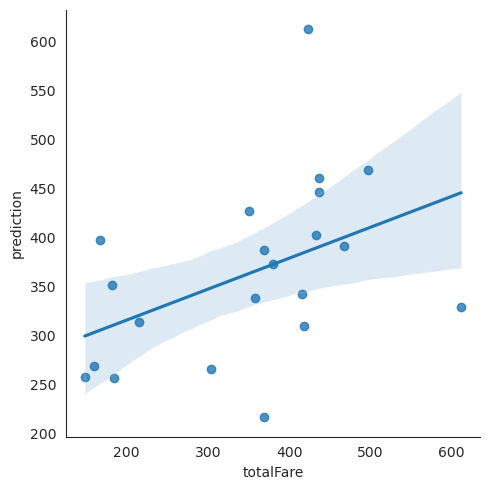

In [7]:
# Visualize regression results

# Plot tip against predicted tip (prediction)
import seaborn as sns

# The Spark dataframe test_results holds the original 'tip' as well as the 'prediction'
# Select and convert to a Pandas dataframe
df = test_results.select('totalFare','prediction').sample(False, 0.000001).toPandas()

# Set the style for Seaborn plots
sns.set_style("white")
 
# Create a relationship plot between tip and prediction
sns.lmplot(x='totalFare', y='prediction', data=df)